In [1]:
# Imports
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.keras import balanced_batch_generator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [2]:
# !pip install -U imbalanced-learn

In [3]:
# Importing the the clean csv
from google.colab import files
data_to_load = files.upload()

Saving df_clean.csv to df_clean.csv


In [4]:
# Creating the dataframe
import io
df = pd.read_csv(io.BytesIO(data_to_load['df_clean.csv']))

In [5]:
# Looking at the rows
df.head()

,swab_type,covid19_test_results,age,high_risk_exposure_occupation,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,days_since_symptom_onset,cough,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,test_name_COVID-19 PCR Test (Curative),test_name_COVID-19 Vitagene At Home Test Kit,test_name_Rapid COVID-19 PCR Test,test_name_Rapid COVID-19 Test,test_name_SARS COV 2 RNA RTPCR,test_name_SARS COV2 NAAT,test_name_SARS CoV w/CoV 2 RNA,"test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, High Risk","test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, Unknown Risk","test_name_SARS-CoV-2, NAA",fever2,high_risk_interactions_False,high_risk_interactions_True,high_risk_interactions_nan,ctab_False,ctab_True,ctab_nan,labored_respiration_False,labored_respiration_True,labored_respiration_nan,rhonchi_False,rhonchi_True,rhonchi_nan,wheezes_False,wheezes_True,wheezes_nan
0,0,0,15,0,0,0,0,0,0,0,0,0,37.00,74.0,123.0,80.0,17,99.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,1,0,20,0,0,0,0,0,0,0,0,0,36.75,88.0,105.0,73.0,12,96.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0
2,0,0,14,0,0,0,0,0,0,0,0,0,36.95,83.0,138.0,61.0,18,99.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1
3,1,0,32,0,0,0,0,0,0,0,0,0,36.85,88.0,160.0,99.0,12,99.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
4,0,0,29,0,0,0,0,0,0,0,0,0,37.00,82.0,111.0,74.0,17,99.0,3.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0


In [6]:
# Checking for nulls and looking at the dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73369 entries, 0 to 73368
Data columns (total 55 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   swab_type                                                         73369 non-null  int64  
 1   covid19_test_results                                              73369 non-null  int64  
 2   age                                                               73369 non-null  int64  
 3   high_risk_exposure_occupation                                     73369 non-null  int64  
 4   diabetes                                                          73369 non-null  int64  
 5   chd                                                               73369 non-null  int64  
 6   htn                                                               73369 non-null  int64  
 7   cancer                         

In [7]:
# Looking at the df columns 
df.columns

Index(['swab_type', 'covid19_test_results', 'age',
       'high_risk_exposure_occupation', 'diabetes', 'chd', 'htn', 'cancer',
       'asthma', 'copd', 'autoimmune_dis', 'smoker', 'temperature', 'pulse',
       'sys', 'dia', 'rr', 'sats', 'days_since_symptom_onset', 'cough', 'sob',
       'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste',
       'runny_nose', 'muscle_sore', 'sore_throat',
       'test_name_COVID-19 PCR Test (Curative)',
       'test_name_COVID-19 Vitagene At Home Test Kit',
       'test_name_Rapid COVID-19 PCR Test', 'test_name_Rapid COVID-19 Test',
       'test_name_SARS COV 2 RNA RTPCR', 'test_name_SARS COV2 NAAT',
       'test_name_SARS CoV w/CoV 2 RNA',
       'test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, High Risk',
       'test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, Unknown Risk',
       'test_name_SARS-CoV-2, NAA', 'fever2', 'high_risk_interactions_False',
       'high_risk_interactions_True', 'high_risk_interactions_nan',
      

In [100]:
# Creating the X and y

features = ['age',
       'high_risk_exposure_occupation', 'diabetes', 'chd', 'htn', 'cancer',
       'asthma', 'copd', 'autoimmune_dis', 'smoker', 'temperature', 'pulse',
       'sys', 'dia', 'rr', 'sats', 'days_since_symptom_onset', 'cough', 'sob',
       'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste',
       'runny_nose', 'muscle_sore', 'sore_throat',
      'fever2', 'high_risk_interactions_False',
       'high_risk_interactions_True', 'high_risk_interactions_nan',
       'ctab_False', 'ctab_True', 'ctab_nan', 'labored_respiration_False',
       'labored_respiration_True', 'labored_respiration_nan', 'rhonchi_False',
       'rhonchi_True', 'rhonchi_nan', 'wheezes_False', 'wheezes_True',
       'wheezes_nan']
X = df[features]
y = df['covid19_test_results']

In [101]:
# Train/ test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [134]:
# Get the baseline
y_test.value_counts(normalize=True)

0    0.982064
1    0.017936
Name: covid19_test_results, dtype: float64

In [104]:
# Instanite the Random Under Sampler
rus = RandomUnderSampler(random_state= 42, replacement=True)


In [105]:
# Fit X and y to Random Under Sampler
X_under, y_under = rus.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [114]:
# Instantiate the model
model = Sequential()

model.add(Dense(1024, input_shape=(X_under.shape[1], ), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))

In [115]:
# Complie the model
model.compile(loss='bce', optimizer='RMSProp', metrics=['acc'])

In [116]:
 # Add early stopping 
 early_stop = EarlyStopping(patience=5)

In [117]:
# Fit the model to the Random Under Sampler X and y
results = model.fit(X_under, y_under, 
                   epochs=25,
                   validation_data=(np.asarray(X_test).astype(np.float32), np.asarray(y_test).astype(np.float32)),
                   verbose=1, 
                   batch_size=256, callbacks=[early_stop]) 

Epoch 1/25
8/8 [==============================] - 2s 152ms/step - loss: 3.2235 - acc: 0.5075 - val_loss: 0.6141 - val_acc: 0.9821
Epoch 2/25
8/8 [==============================] - 1s 128ms/step - loss: 1.1541 - acc: 0.4860 - val_loss: 0.6412 - val_acc: 0.9812
Epoch 3/25
8/8 [==============================] - 1s 130ms/step - loss: 0.8292 - acc: 0.5091 - val_loss: 0.6564 - val_acc: 0.9820
Epoch 4/25
8/8 [==============================] - 1s 135ms/step - loss: 0.7954 - acc: 0.5020 - val_loss: 0.6616 - val_acc: 0.9543
Epoch 5/25
8/8 [==============================] - 1s 129ms/step - loss: 0.7273 - acc: 0.4770 - val_loss: 0.7123 - val_acc: 0.0796
Epoch 6/25
8/8 [==============================] - 1s 134ms/step - loss: 0.7197 - acc: 0.5134 - val_loss: 0.6824 - val_acc: 0.9800


In [118]:
# Check the MSE on the testing data
model.evaluate(np.asarray(X_test).astype(np.float32), np.asarray(y_test).astype(np.float32))

574/574 [==============================] - 2s 3ms/step - loss: 0.6824 - acc: 0.9800


[0.6823811531066895, 0.9799923896789551]

In [119]:
 # Prediciting the X_test and creating y_pred
y_pred = model.predict_classes(np.asarray(X_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [121]:
# Creating y_true from y_test 
y_true=np.asarray(y_test)

In [123]:
# Looking at the confusion matrix 
print(confusion_matrix(y_true,y_pred))

[[17975    39]
 [  328     1]]


In [124]:
# Unraveling the confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()

In [125]:
# True negative
tn

17975

In [126]:
# False positive 
fp

39

In [127]:
# False negative 
fn

328

In [128]:
# True positive 
tp

1

In [129]:
# Recall score 
metrics.recall_score(y_true=y_true, y_pred=y_pred)

0.00303951367781155

In [137]:
# F1- score 
metrics.f1_score(y_true=y_true, y_pred=y_pred)

0.005420054200542005

In [140]:
# Precision score 
metrics.precision_score(y_true=y_true, y_pred=y_pred)

0.025

In [130]:
# Looking at the results dictionary 
results.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

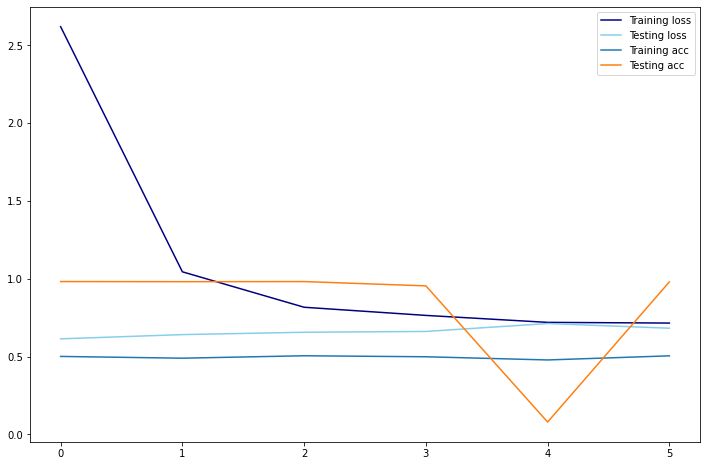

In [142]:
# Graphing the Loss and Accuracy from the results 
train_loss = results.history['loss']
test_loss = results.history['val_loss']
train_acc = results.history['acc']
test_acc = results.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_acc, label='Training acc')
plt.plot(test_acc, label='Testing acc')
plt.legend();